## Алгоритмы анализа данных.
### Урок 7. Классификация с помощью KNN. Кластеризация K-means.

In [20]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

In [21]:
# Загрузим один из "игрушечных" датасетов из sklearn
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [22]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

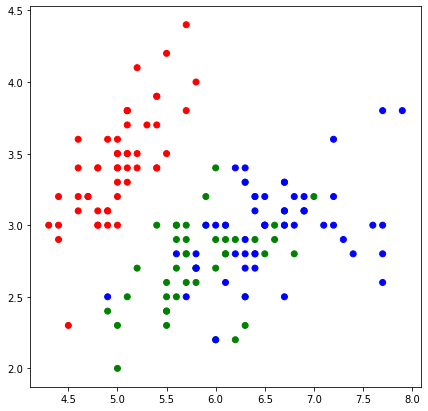

In [23]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [24]:
# Напишем функцию для вычисления точности
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [25]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [26]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

#### 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

- $w(d) = q^{d}$,   $q \in (0,1)$;

- $w(d) = \frac{1}{(d+a)^{b}}$

In [27]:
# Метрика Минковского
def m_metrics(x1, x2, q):
    return np.sum(np.abs(x1 - x2) ** q) ** (1 / q)

def powered_weight(x1, x2, q):
    return q ** (m_metrics(x1, x2, 2))

def inversed_weight(obj, data, a, b):
    return 1 / ((m_metrics(x1, x2, 2) + a) ** b)

#### Реализация 1

In [28]:
def knn_powered_weight_distance(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
        # Введем коэффициент для вычисления весов
        q = 0.5
        # Будем использовать евклидову метрику
        p = 2
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            weight = powered_weight(x, x_train[i], q)
            distance = m_metrics(x, x_train[i], p)
            # Записываем в список значение расстояния, ответа на объекте обучающей выборки и веса 
            test_distances.append((distance, y_train[i], weight))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем сумму весов разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += d[2]
            
        # Записываем в список ответов наиболее весомый класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [29]:
def get_graph_powered_weight_distance(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn_powered_weight_distance(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [30]:
k = 9

y_pred = knn_powered_weight_distance(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 9: 0.867


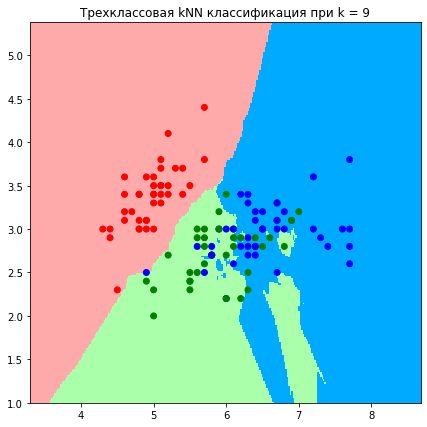

Wall time: 3min 12s


In [31]:
%%time
get_graph_powered_weight_distance(X_train, y_train, k)

#### Реализация 2

In [32]:
def knn_inversed_weight_distance(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
        # Введем коэффициенты для вычисления весов
        a, b = 1, 2
        # Будем использовать евклидову метрику
        p = 2
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            weight = inversed_weight(x, x_train[i], 1, 2)
            distance = m_metrics(x, x_train[i], p)
            # Записываем в список значение расстояния, ответа на объекте обучающей выборки и веса 
            test_distances.append((distance, y_train[i], weight))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем сумму весов разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += d[2]
            
        # Записываем в список ответов наиболее весомый класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [33]:
def get_graph_inversed_weight_distance(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn_inversed_weight_distance(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [34]:
k = 9

y_pred = knn_powered_weight_distance(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 9: 0.867


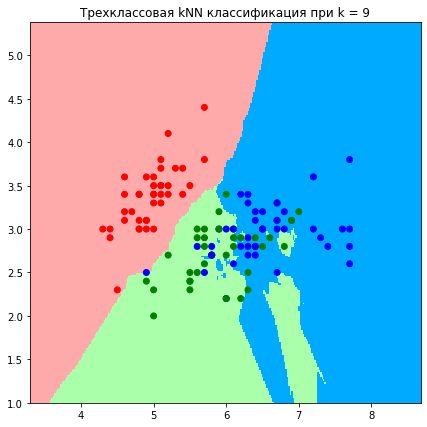

Wall time: 3min 17s


In [35]:
%%time
get_graph_powered_weight_distance(X_train, y_train, k)

#### 2*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [36]:
# Среднеквадратичное расстояние внутри кластера
def get_data_radius(data, centroid):
    res = 0
    n = len(data)
    for i in range(n):
        res += m_metrics(data[i], centroid, 2) / n
    return res        

# На входе - данные и метки. Классифицируем данные по kmeans и возвращаем требуемое
def accuracy_my(data, k, max_iterations, min_distance):
    centroids, classes = kmeans(data, k, max_iterations, min_distance)
    res = 0
    n = len(classes)
    for i in classes:
        res += get_data_radius(classes[i], centroids[i]) / n
    return res

In [37]:
max_iterations = 3
min_distance = 1e-4
y = []
x = np.arange(1, 11)
for k in x:
    y.append(accuracy_my(X_train, k, max_iterations, min_distance))

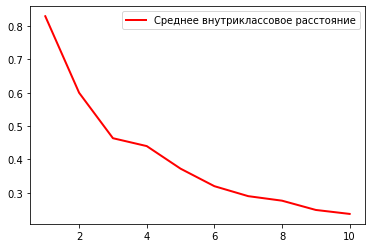

In [38]:
fig, ax = plt.subplots()
ax.plot(x, y,
        linestyle = '-',
        linewidth = 2,
        color = 'r',
        label='Среднее внутриклассовое расстояние')
ax.legend()